# 1. Predicting house prices: a MLP regression example

We will be attempting to predict the median price of homes in a given Boston suburb in the mid-1970s, given a few data points about the 
suburb at the time, such as the crime rate, the local property tax rate, etc.

The dataset has very few data points, only 506 in 
total, split between 404 training samples and 102 test samples, and each "feature" in the input data (e.g. the crime rate is a feature) has 
a different scale. For instance some values are proportions, which take a values between 0 and 1, others take values between 1 and 12, 
others between 0 and 100...

Let's take a look at the data:

In [5]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [6]:
train_data.shape

(404, 13)

In [8]:
test_data.shape

(102, 13)

In [9]:
import pandas as pd
df_train = pd.DataFrame(train_data)
df_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000



As you can see, we have 404 training samples and 102 test samples. The data comprises 13 features. The 13 features in the input data are as 
follow:

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

The targets are the median values of owner-occupied homes, in thousands of dollars:

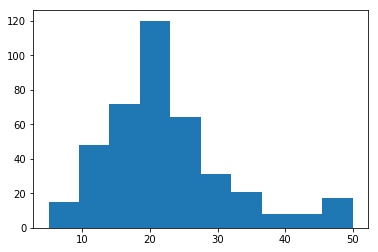

In [10]:
import matplotlib.pyplot as plt
plt.hist(train_targets)
plt.show()


The prices are typically between \$10,000 and \$35,000. If that sounds cheap, remember this was the mid-1970s, and these prices are not 
inflation-adjusted.

## Preparing the data: Nomalization


It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to 
automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal 
with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we 
will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a 
unit standard deviation. This is easily done in Numpy:

In [11]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [12]:
df_train.describe()## to understand the effect of feature normalization 

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02
mean,-1.015414e-16,1.099231e-17,1.809334e-15,-7.804538e-17,-5.250476e-15,6.431874e-15,2.984411e-16,4.946538e-16,1.126711e-17,-1.055261e-16,2.366149e-14,5.967105e-15,6.139204e-16
std,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00
min,-4.051005e-01,-4.836155e-01,-1.564696e+00,-2.568327e-01,-1.471269e+00,-3.817250e+00,-2.369042e+00,-1.287503e+00,-9.715693e-01,-1.311311e+00,-2.673752e+00,-3.771101e+00,-1.519664e+00
25%,-3.969615e-01,-4.836155e-01,-8.782218e-01,-2.568327e-01,-8.908055e-01,-5.534305e-01,-8.433882e-01,-8.202251e-01,-6.262491e-01,-7.636737e-01,-5.692381e-01,2.116008e-01,-8.075036e-01
50%,-3.766520e-01,-4.836155e-01,-2.079167e-01,-2.568327e-01,-1.652266e-01,-9.674263e-02,3.400464e-01,-2.949009e-01,-5.111423e-01,-4.567563e-01,2.839433e-01,3.879673e-01,-1.857436e-01
75%,-7.617386e-03,4.296024e-02,1.028326e+00,-2.568327e-01,6.286420e-01,4.823165e-01,8.990647e-01,6.794540e-01,1.675886e+00,1.565287e+00,7.844764e-01,4.401777e-01,6.005999e-01
max,9.234847e+00,3.728990e+00,2.445374e+00,3.893584e+00,2.677335e+00,3.467186e+00,1.110488e+00,3.437406e+00,1.675886e+00,1.836097e+00,1.603531e+00,4.480771e-01,3.482019e+00



Note that the quantities that we use for normalizing the test data have been computed using the training data. We should never use in our 
workflow any quantity computed on the test data, even for something as simple as data normalization.

## Building our network


Because so few samples are available, we will be using a very small network with two 
hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using 
a small network is one way to mitigate overfitting.

In [14]:
from keras import models
from keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


Our network ends with a single unit, and no activation (i.e. it will be linear layer). 
This is a typical setup for scalar regression (i.e. regression where we are trying to predict a single continuous value). 
Applying an activation function would constrain the range that the output can take; for instance if 
we applied a `sigmoid` activation function to our last layer, the network could only learn to predict values between 0 and 1. Here, because 
the last layer is purely linear, the network is free to learn to predict values in any range.

Note that we are compiling the network with the `mse` loss function -- **Mean Squared Error**, the square of the difference between the 
predictions and the targets, a widely used loss function for regression problems.

We are also monitoring a new metric during training: `mae`. This stands for **Mean Absolute Error**. It is simply the absolute value of the 
difference between the predictions and the targets. For instance, a MAE of 0.5 on this problem would mean that our predictions are off by 
\$500 on average.

## Validating our approach using K-fold validation


To evaluate our network while we keep adjusting its parameters (such as the number of epochs used for training), we could simply split the 
data into a training set and a validation set, as we were doing in our previous examples. However, because we have **so few data points**, the 
validation set would end up being very small (e.g. about 100 examples). A consequence is that our validation scores may change a lot 
depending on _which_ data points we choose to use for validation and which we choose for training, i.e. the validation scores may have a 
high _variance_ with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use **K-fold cross-validation**. It consists of splitting the available data into K partitions 
(typically K=4 or 5), then instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining 
partition. The validation score for the model used would then be the average of the K validation scores obtained.

In [15]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [16]:
all_scores

[2.113312747218821, 2.1556942887825543, 2.9771997480109187, 2.3096999360783266]

In [17]:
np.mean(all_scores)

2.388976680022655


As you can notice, the different runs do indeed show rather different validation scores, from 2.0 to 2.9. Their average is a much more 
reliable metric than any single of these scores -- that's the entire point of K-fold cross-validation. In this case, we are off by \$2,300 on 
average, which is still significant considering that the prices range from \$10,000 to \$50,000. 

In [18]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

# Let’s try training the network with 500 epochs 

 plot and Building the history of successive mean K-fold validation scores


In [19]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)

# Prepare the validation data: data from partition # k
val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
# Prepare the training data: data from all other partitions
partial_train_data = np.concatenate(
[train_data[:i * num_val_samples],
train_data[(i + 1) * num_val_samples:]],
axis=0)
partial_train_targets = np.concatenate(
[train_targets[:i * num_val_samples],
train_targets[(i + 1) * num_val_samples:]],
axis=0)
# Build the Keras model (already compiled)
model = build_model()
# Train the model (in silent mode, verbose=0)
history = model.fit(partial_train_data, partial_train_targets,
validation_data=(val_data, val_targets),
epochs=num_epochs, batch_size=1, verbose=0)
mae_history = history.history['val_mean_absolute_error']
all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [23]:
average_mae_history = [
np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

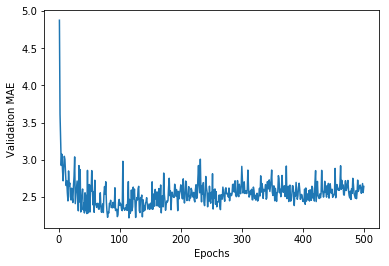

In [26]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Smoothing

Omit the first 10 data points that are on a different scale from the rest of the curve.
Replace each point with an exponential moving average of the previous points, to obtain
a smooth curve.

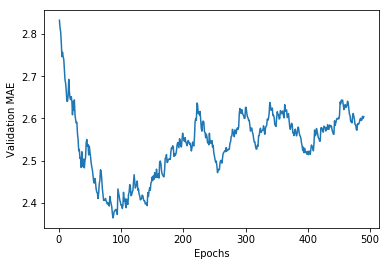

In [27]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [38]:
#Get a fresh, compiled model.
model1 = build_model()
# Train it on the entirety of the data.
model1.fit(train_data, train_targets,epochs=80, batch_size=16, verbose=0)
test_mse_score1, test_mae_score1 = model1.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 615us/step


In [39]:
test_mae_score

2.7091367384966683

In [40]:
model2 = build_model()

model2.fit(train_data, train_targets,epochs=100, batch_size=8, verbose=0)
test_mse_score2, test_mae_score2 = model2.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 659us/step


In [41]:
test_mae_score2

2.563603952819226

In [44]:
model3 = build_model()

model3.fit(train_data, train_targets,epochs=200, batch_size=8, verbose=0)
test_mse_score3, test_mae_score3 = model3.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 657us/step


In [45]:
test_mae_score3

2.6934188113493076

In [46]:
y_pred = model3.predict(test_data)
y_pred

array([[ 9.969848 ],
       [19.61169  ],
       [21.033535 ],
       [35.779613 ],
       [24.87347  ],
       [23.85569  ],
       [29.840763 ],
       [22.610313 ],
       [20.494308 ],
       [21.356989 ],
       [22.879135 ],
       [18.300678 ],
       [14.725566 ],
       [45.645557 ],
       [19.428947 ],
       [21.862656 ],
       [26.537651 ],
       [19.367126 ],
       [19.2766   ],
       [23.629852 ],
       [12.463325 ],
       [12.559619 ],
       [21.347628 ],
       [14.237146 ],
       [21.319921 ],
       [24.645576 ],
       [29.288181 ],
       [33.104214 ],
       [13.271537 ],
       [19.703564 ],
       [20.034431 ],
       [16.051664 ],
       [36.03909  ],
       [24.724903 ],
       [19.957355 ],
       [ 9.146233 ],
       [19.870493 ],
       [17.866573 ],
       [18.612766 ],
       [28.56472  ],
       [33.78098  ],
       [28.75057  ],
       [13.747988 ],
       [47.34348  ],
       [30.686743 ],
       [28.693207 ],
       [29.600885 ],
       [20.43

1.Regression is done using different loss functions from classification; Mean Squared Error (MSE) is a commonly used loss function for regression.

2.Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally the concept of "accuracy" does not apply for regression. A common regression metric is Mean Absolute Error (MAE).

3.When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.

4.When there is little data available, using K-Fold validation is a great way to reliably evaluate a model.

5.When little training data is available, it is preferable to use a small network with very few hidden layers (typically only one or two), in order to avoid severe overfitting.